In [1]:
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os

In [2]:
# define functions used for plotting 
def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(x) & ~np.isnan(y) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

'1.10.4'

In [2]:
# automatically download data 
# stationIDs = {'Baltimore': 'USW00093784',}
# import ulmo
# st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)
#st[st.name.str.contains('BIRMINGHAM')]

In [3]:
pairs = pd.read_csv('GHCNpairedstations.csv')

In [169]:
df = pairs[pairs['Urban station'].str.contains('US')]

In [5]:
df.shape

(33, 10)

Ciudad Juárez


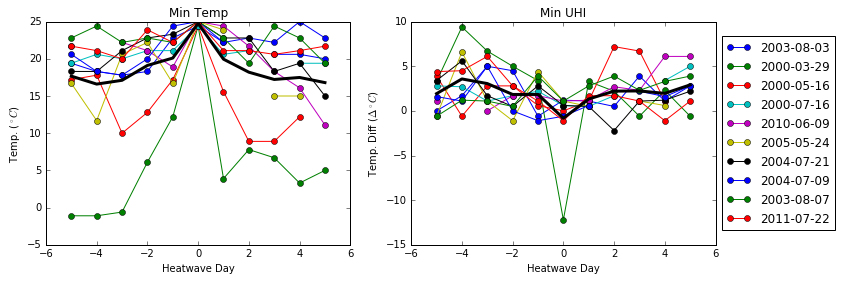

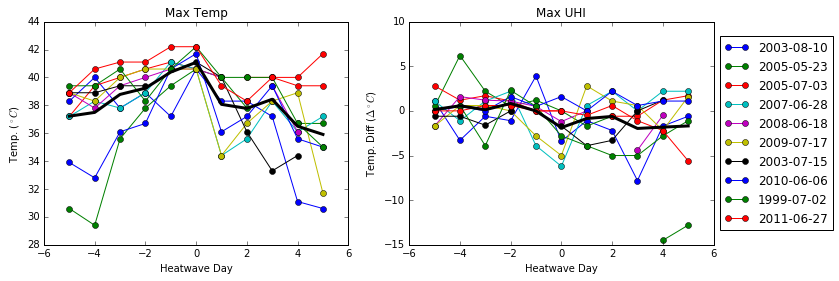

In [261]:
dict = ['Min', 'Max']

for i in range(0, 1):#df.shape[0]): 
    city = df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = df.iloc[i]['Urban station']
    ruralID = df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()): 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1965
        tmin = pd.to_numeric(ruraldata['TMIN']['1965-01-01':].value/10.) 
        filename = './data/mindailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            minthresh = np.load(filename)
        else: 
            summary = tmin.dropna().groupby(tmin.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/mindailytempthresholds'+city), minthresh)

        # Calculate maximum  daily thresholds
        tmax = pd.to_numeric(ruraldata['TMAX']['1965-01-01':].value/10.) 
        filename = './data/maxdailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            maxthresh = np.load(filename)
        else: 
            summary = tmax.dropna().groupby(tmax.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/maxdailytempthresholds'+city), maxthresh)

        numhw = 30 # number of heatwaves

        # min hw
        tmin = tmin[startdate:]
        hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
        minheatwaves = hottestmin
        
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        minheatwaves = minheatwaves.sort_values().iloc[0:10]

#         ind = np.where(hottestmin.values- minthresh[1,hottestmin.index.dayofyear] >0)
#         minheatwaves = hottestmin.iloc[ind]
#         # check that these are heatwaves
#         ind2 = np.where(minheatwaves- minthresh[1,hottestmin.index.dayofyear+1] >0)[0]
#         minheatwaves = minheatwaves[ind2]
        # check that these last 48 hours 

        # check that these aren't all the same event : must be at least 3 days apart? 

        # max hw
        tmax = tmax[startdate:]
        hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]]# Get the hottest days based off tmax
        maxheatwaves = hottestmax
#         ind = np.where(hottestmax.values- maxthresh[1,hottestmax.index.dayofyear] >0)
#         maxheatwaves = hottestmax.iloc[ind]
#         # check that these last 48 hours
#         ind2 = np.where(maxheatwaves- maxthresh[1,hottestmax.index.dayofyear+1] >0)[0]
#         maxheatwaves = maxheatwaves[ind2]
        # check that these aren't all the same event
    
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (maxheatwaves.sort_index().index.to_timestamp().values[1:] - maxheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        maxheatwaves = maxheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        maxheatwaves = maxheatwaves.sort_values().iloc[0:10]
        
        if minheatwaves.shape[0]==0: 
            print 'No min heatwaves detected for %s' %city
        if maxheatwaves.shape[0]==0: 
            print 'No Max heatwaves detected for %s' %city
        if 'AWND' in urbandata.keys():
            wind = pd.to_numeric(urbandata['AWND'][startdate:].value) 
        elif 'AWND' in ruraldata.keys():
            wind = pd.to_numeric(ruraldata['AWND'][startdate:].value)
        else: 
            wind = np.zeros(temp.shape)
            wind[:] = np.nan
            print 'No wind data'

        #calculate UHI
        UHImin = pd.to_numeric(urbandata['TMIN'].value/10.) - tmin
        UHImax = pd.to_numeric(urbandata['TMAX'].value/10.) - tmax
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([minheatwaves.shape[0], 11])
        compositeUHI = np.zeros([minheatwaves.shape[0], 11])
        composite_wind = np.zeros([minheatwaves.shape[0], 11])    

        j = 0
        for UHI, temp, heatwaves in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves]): 
                minmax = dict[j]
                i = 0
                try: 
                    for dates in heatwaves.index[:]: 
                        compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        composite_wind[i,:] = wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        i = i+1

                    plt.figure(figsize=[12,4])
                    plt.subplot(1,2,1)
                    tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
                    plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
                    #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
                    try: 
                        plt.title('%s %s Temp'%(minmax, city))
                    except UnicodeDecodeError : 
                        plt.title('%s Temp'%(minmax))

                    plt.ylabel('Temp. ($^\circ C$)')
                    plt.xlabel('Heatwave Day')

                    plt.subplot(1,2,2)    
                    uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
                    plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
                    try: 
                        plt.title('%s %s UHI'%(minmax, city))
                    except UnicodeDecodeError : 
                        plt.title('%s UHI'%(minmax))
                    plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
                    plt.xlabel('Heatwave Day')
                    plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
                    
                    #plt.savefig('plots/hwUHI%s%s.png'%(minmax, city.replace(" ", "")[0:5]))
                except ValueError: 
                    print 'Error plotting ', city
                j = j+1  
        #plt.clf()       
    else: 
        print 'Skipping %s'%city

In [306]:
def hw_scatter(x,y,title, xlabel, ylabel) : 
    ind = ~np.isnan(x) & ~np.isnan(y) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

In [ ]:
dict = ['Min', 'Max']

for i in range(2, df.shape[0]): 
    city = df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = df.iloc[i]['Urban station']
    ruralID = df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN'].index, ruraldata['TMIN'].index).shape[0] > 50): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1965
        tmin = pd.to_numeric(ruraldata['TMIN']['1965-01-01':].value/10.) 
        filename = './data/mindailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            minthresh = np.load(filename)
        else: 
            summary = tmin.dropna().groupby(tmin.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/mindailytempthresholds'+city), minthresh)

        # Calculate maximum  daily thresholds
        tmax = pd.to_numeric(ruraldata['TMAX']['1965-01-01':].value/10.) 
        filename = './data/maxdailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            maxthresh = np.load(filename)
        else: 
            summary = tmax.dropna().groupby(tmax.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/maxdailytempthresholds'+city), maxthresh)

        numhw = 30 # number of heatwaves

        # min hw
        tmin = tmin[startdate:]
        hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
        minheatwaves = hottestmin
        
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        minheatwaves = minheatwaves.sort_values().iloc[0:10]

        # max hw
        tmax = tmax[startdate:]
        hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]]# Get the hottest days based off tmax
        maxheatwaves = hottestmax

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (maxheatwaves.sort_index().index.to_timestamp().values[1:] - maxheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        maxheatwaves = maxheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        maxheatwaves = maxheatwaves.sort_values().iloc[0:10]
        
        if minheatwaves.shape[0]==0: 
            print 'No min heatwaves detected for %s' %city
        if maxheatwaves.shape[0]==0: 
            print 'No Max heatwaves detected for %s' %city
        
        # Import wind data 
        if 'AWND' in urbandata.keys():
            wind = pd.to_numeric(urbandata['AWND'][startdate:].value) 
        elif 'AWND' in ruraldata.keys():
            wind = pd.to_numeric(ruraldata['AWND'][startdate:].value)
        else: 
            wind = pd.DataFrame(index=tmin.index, columns=['Wind'])
            wind = wind.fillna('NaN') # with 0s rather than NaNs
            #wind = np.zeros(temp.shape)
            #wind[:] = np.nan
            print 'No wind data'
    
        if wind.shape[0]==0 : 
            wind = pd.DataFrame(index=tmin.index, columns=['Wind'])
            wind = wind.fillna('NaN') # with 0s rather than NaNs
            #wind = np.zeros(temp.shape)
            #wind[:] = np.nan
            print 'No wind data'
            
        #calculate UHI
        UHImin = pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([minheatwaves.shape[0], 11])
        compositeUHI = np.zeros([minheatwaves.shape[0], 11])
        composite_wind = np.zeros([minheatwaves.shape[0], 11])  

     
        j = 0 
        for UHI, temp, heatwaves, HWthresh in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves], [minthresh[1], maxthresh[1]]):
            #calculate hw index
            hw_day_index = np.where(temp - HWthresh[temp.index.day_of_year-1] >=0)

            minmax = dict[j]
            i = 0

            for dates in heatwaves.index[:]: 
                compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                try: 
                    composite_wind[i,:] = np.squeeze(wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values)
                except ValueError: 
                    composite_wind[i,:] = np.nan
                #composite_wind[i,:] = np.squeeze(wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values)
                i = i+1

            plt.figure(figsize=[20,4])
            # plot temperature 
            plt.subplot(1,5,1)
            tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
            #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
            plt.title('%s %s Temp'%(city, minmax))
            plt.ylabel('Temp. ($^\circ C$)')
            plt.xlabel('Heatwave Day')

            # plot UHI
            plt.subplot(1,5,2)    
            uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
            plt.title('%s %s UHI'%(city, minmax))
            plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
            plt.xlabel('Heatwave Day')
            plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

            # scatter temp versus UHI
            # calculate the heatwave days
            plt.subplot(1,5,4)         
            x = temp.iloc[hw_day_index].values
            y = UHI[temp.iloc[hw_day_index].index].values 
            hw_scatter(x, y, '%s Temp vs UHI HW days'%(minmax), 'Temp', 'UHI')

            plt.subplot(1,5,5)
            x = temp.drop(temp.index[hw_day_index], inplace=False)
            y = UHI[x.index].values
            x = x.values
            hw_scatter(x, y, '%s Temp vs UHI non-HW days'%(minmax), 'Temp', 'UHI')
            if j == 0 : 
                plt.savefig('plots/hwUHI%s%s.png'%(city.replace(" ", "")[0:5], minmax))

            j = j+1

        plt.subplot(1,5,3)
        uhiHandle = plt.plot(np.arange(-5,6,1),composite_wind.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(composite_wind, axis=0), linewidth = 3,color = 'black')
        plt.title('%s Avg. Wind'%(city))
        plt.ylabel('Wind')
        plt.xlabel('Heatwave Day')
        
        plt.savefig('plots/hwUHI%s%s.png'%(city.replace(" ", "")[0:5], minmax))
        plt.close("all")

Irvine
Long Beach
Columbus
Ft. Worth
No wind data
Indianapolis
Baltimore
No wind data
San Jose


make sure that events are unique: sort will work differently for max and min heatwaves. Make sure this is functioning properly. figure out why in Ciudad Jaurez there are events being picked up that are below 0 

Aim for 4 panel: temp, UHI, HW temp versus UHI, non-HW temp versus UHI
wind below 

Make a hw_scatter function and a hw_composite_plot function to reduce space in code?

In [ ]:
# cut off UHI at some year 
# Other things to plot
# max hw versus min hw
# mean windspeed during the event : AWND
# relative humidity during the event : 
# scatter plot UHI versus temp during the event, UHI versus temp for all time 

In [391]:
wind.shape

(0,)